In [21]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split



In [22]:
paths = []
labels = []
for dirname, _, filenames in os.walk("TESS Toronto emotional speech set data/"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [23]:
len(paths)

2800

In [24]:
paths[:5]

['TESS Toronto emotional speech set data/OAF_angry\\OAF_back_angry.wav',
 'TESS Toronto emotional speech set data/OAF_angry\\OAF_bar_angry.wav',
 'TESS Toronto emotional speech set data/OAF_angry\\OAF_base_angry.wav',
 'TESS Toronto emotional speech set data/OAF_angry\\OAF_bath_angry.wav',
 'TESS Toronto emotional speech set data/OAF_angry\\OAF_bean_angry.wav']

In [25]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [26]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,TESS Toronto emotional speech set data/OAF_ang...,angry
1,TESS Toronto emotional speech set data/OAF_ang...,angry
2,TESS Toronto emotional speech set data/OAF_ang...,angry
3,TESS Toronto emotional speech set data/OAF_ang...,angry
4,TESS Toronto emotional speech set data/OAF_ang...,angry


In [27]:
df['label'].value_counts()

label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

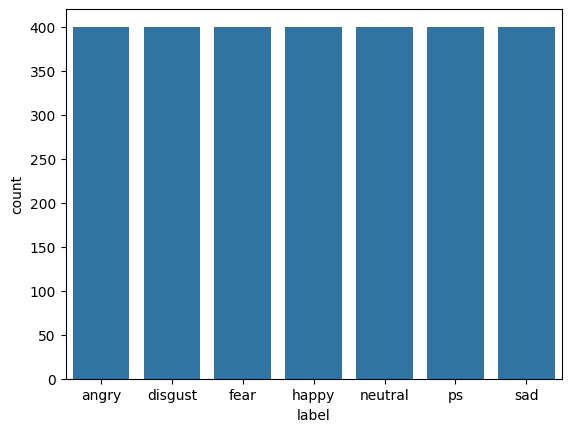

In [28]:
import seaborn as sns
sns.countplot(data=df, x='label')

In [29]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [30]:
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

--- ANGRY ---


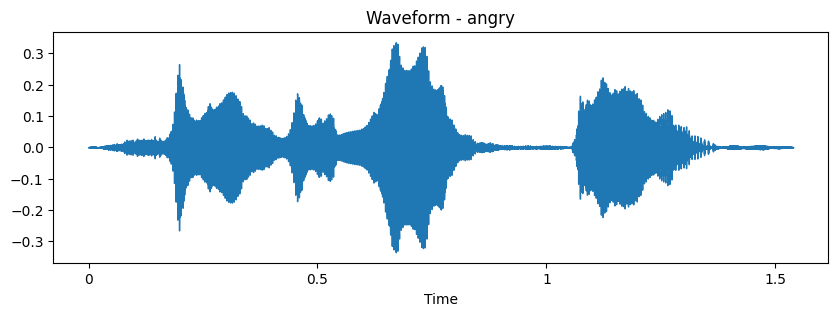

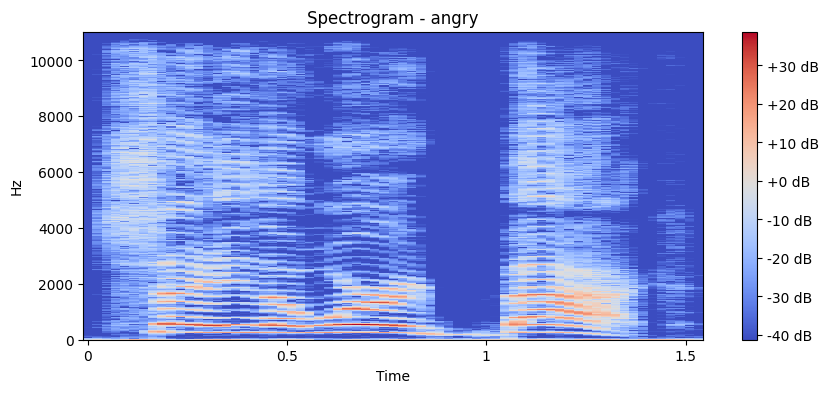

--- DISGUST ---


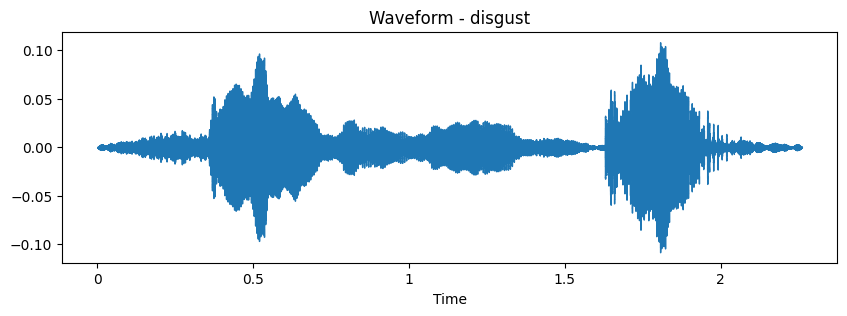

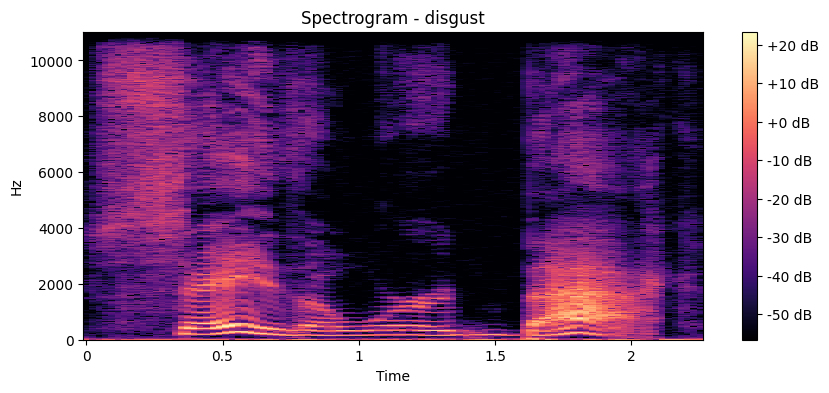

--- FEAR ---


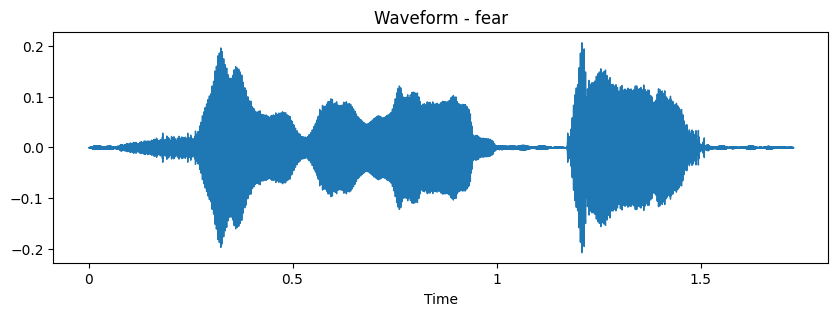

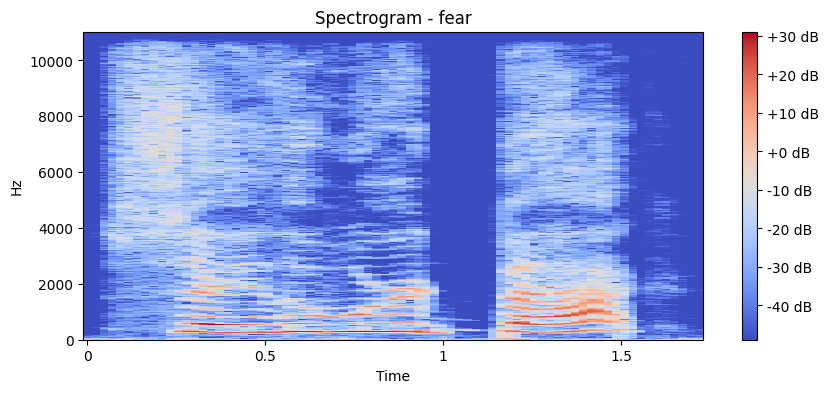

--- HAPPY ---


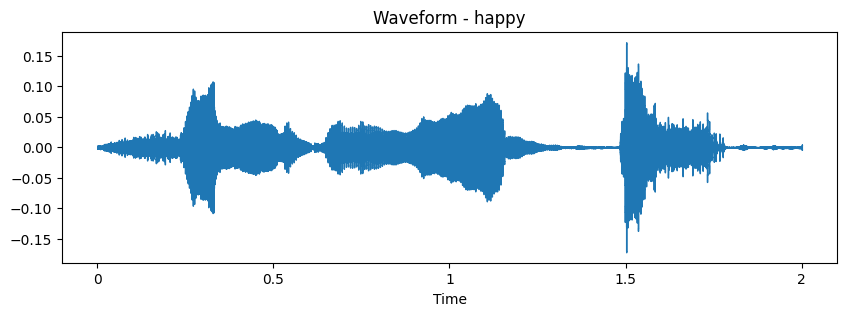

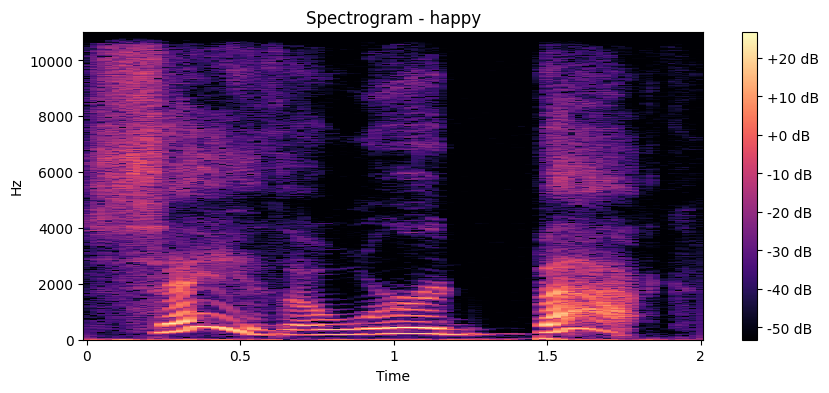

--- NEUTRAL ---


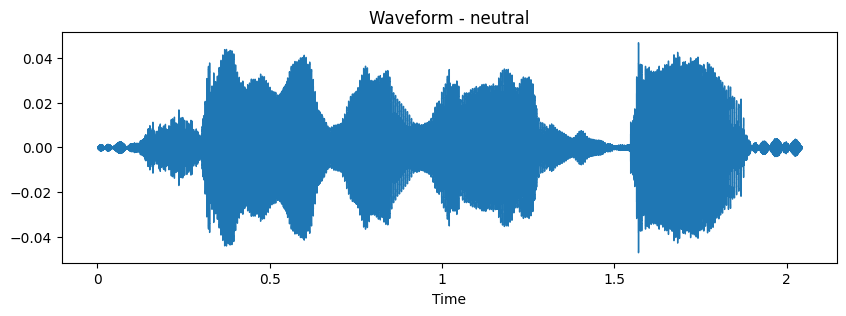

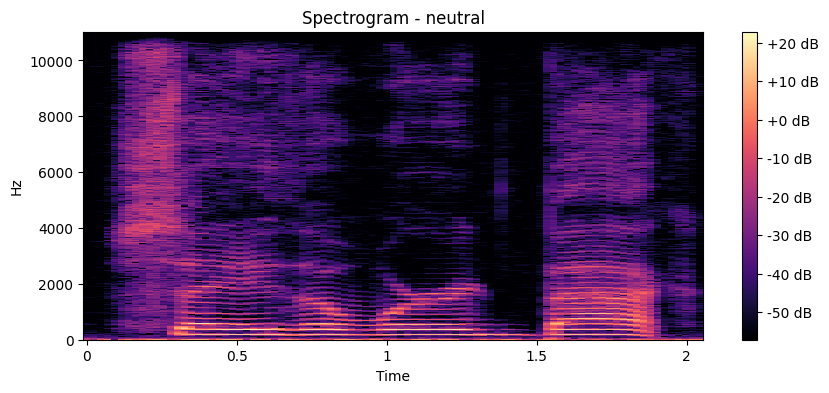

--- PS ---


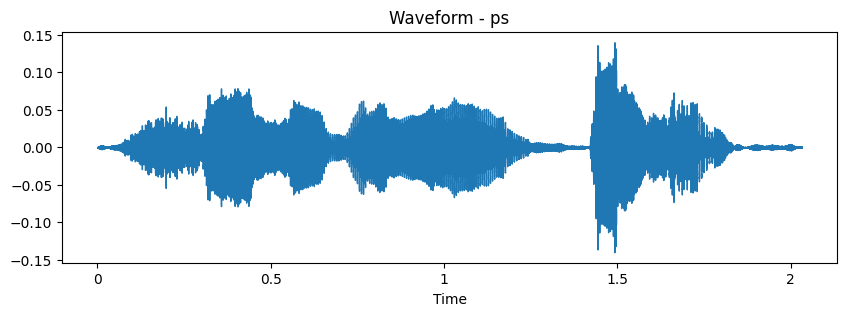

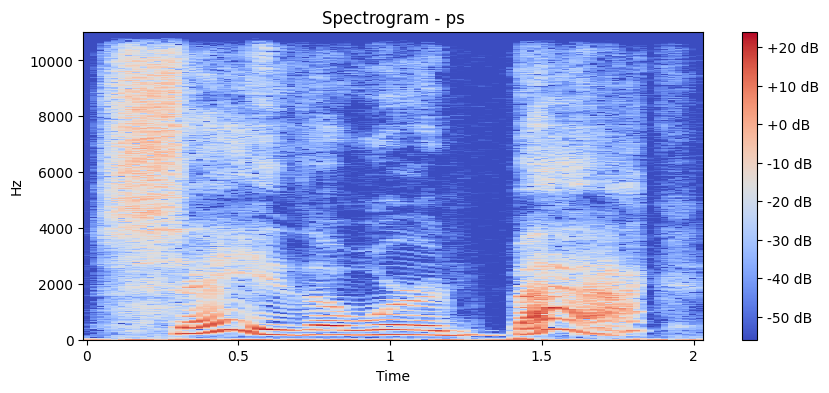

--- SAD ---


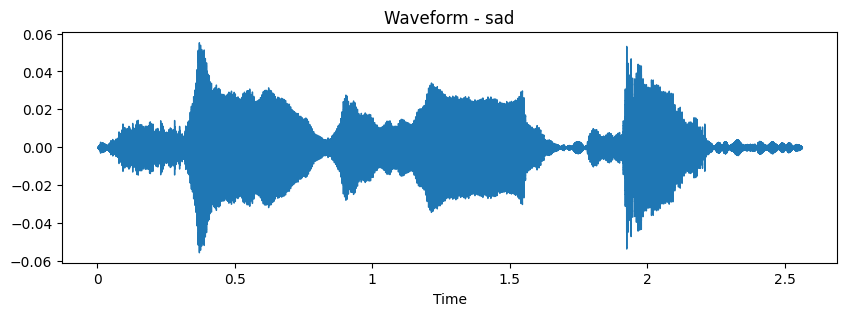

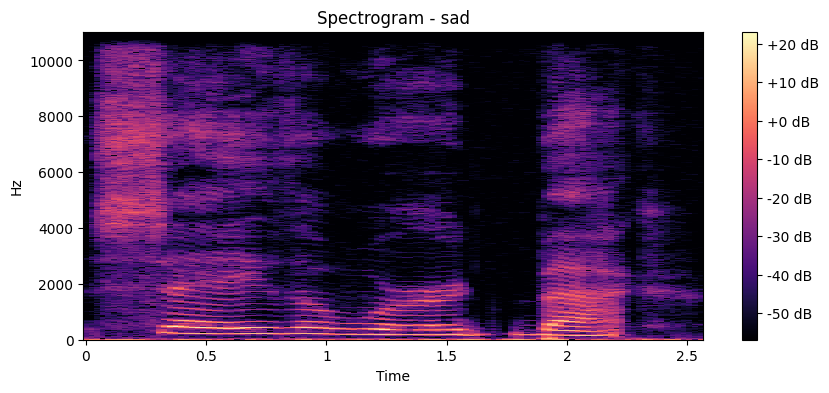

In [31]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

# Waveform plotting function
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(data, sr=sr)
    plt.title(f"Waveform - {emotion}")
    plt.show()

# Spectrogram plotting function
def spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram - {emotion}")
    plt.show()

# Loop through each emotion in the dataset
for emotion in df['label'].unique():
    print(f"--- {emotion.upper()} ---")
    
    # Get one sample path for this emotion
    path = np.array(df['speech'][df['label'] == emotion])[0]
    
    # Load audio
    data, sampling_rate = librosa.load(path)
    
    # Plot waveform
    waveplot(data, sampling_rate, emotion)
    
    # Plot spectrogram
    spectrogram(data, sampling_rate, emotion)
    
    # Play audio
    display(Audio(path))


In [32]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [33]:
extract_mfcc(df['speech'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275601e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228313e+00, -5.57366073e-01, -1.83255339e+00,  2.02101618e-01,
        7.27550924e-01,  1.31773746e+00,  2.88633800e+00,  2.85579062e+00,
       -4.71292210e+00, -4.43651056e+00, -1.62115955e+00, -1.02398405e+01,
       -7.55126143e+00, -1.79688025e+00, -7.03765249e+00,  9.43658352e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169914e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917236e+00,  3.94722193e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996375e+00, -1.82390714e+00,
        4.86896229e+00,  9.31392288e+00,  2.08914971e+00, -1.90649164e+00],
      dtype=float32)

In [34]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [35]:
X = np.expand_dims(np.stack(X_mfcc.values),-1)
X.shape

(2800, 40, 1)

In [36]:
X.shape

(2800, 40, 1)

In [37]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [38]:
y= y.toarray()

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# X: shape [n_samples, n_features] built from MFCC mean/std/delta/delta-delta
# y: integer labels 0..6
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Reshape X_train and X_test to 2D
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Convert one-hot labels to integer class labels
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced"))
clf.fit(X_train_2d, y_train_int)
print(classification_report(y_test_int, clf.predict(X_test_2d)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00        78
           2       1.00      1.00      1.00        89
           3       1.00      1.00      1.00        77
           4       1.00      1.00      1.00        73
           5       1.00      1.00      1.00        87
           6       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define model path
model_path = "cnn_tess.h5"

# Helper function to extract log-mel spectrograms
def extract_logmel(path, n_mels=128, duration=3, offset=0.5):
    y, sr = librosa.load(path, duration=duration, offset=offset)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    # Ensure shape is (T, F, 1)
    log_S = log_S.T[..., np.newaxis]
    return log_S

# Extract log-mel spectrograms for all samples
Xspec_list = [extract_logmel(p) for p in df['speech']]
# Pad/truncate to fixed length (e.g., 130 frames)
max_len = 130
n_mels = 128
Xspec_pad = np.zeros((len(Xspec_list), max_len, n_mels, 1), dtype=np.float32)
for i, x in enumerate(Xspec_list):
    length = min(x.shape[0], max_len)
    Xspec_pad[i, :length, :, :] = x[:length, :, :]

# Use y for one-hot labels
y_onehot = y

# Split into train/val
from sklearn.model_selection import train_test_split
Xspec_train, Xspec_val, y_onehot_train, y_onehot_val = train_test_split(Xspec_pad, y_onehot, test_size=0.2, random_state=42)

inp = layers.Input(shape=(max_len, 128, 1))   # (time, mel, 1)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inp)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(7, activation='softmax')(x)

model = models.Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(Xspec_train, y_onehot_train,
          validation_data=(Xspec_val, y_onehot_val),
          epochs=25, batch_size=32,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])



Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 695ms/step - accuracy: 0.7214 - loss: 0.9922 - val_accuracy: 0.2679 - val_loss: 2.7097
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 668ms/step - accuracy: 0.9272 - loss: 0.4788 - val_accuracy: 0.5143 - val_loss: 1.3548
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 46s 660ms/step - accuracy: 0.9625 - loss: 0.2776 - val_accuracy: 0.8143 - val_loss: 0.6276
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 84s 681ms/step - accuracy: 0.9915 - loss: 0.1486 - val_accuracy: 0.8036 - val_loss: 0.5108
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 672ms/step - accuracy: 0.9888 - loss: 0.1069 - val_accuracy: 0.3411 - val_loss: 2.2328
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 673ms/step - accuracy: 0.9969 - loss: 0.0691 - val_accuracy: 0.8250 - val_loss: 0.4469
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 616ms/step - accuracy: 0.9951 - loss: 0.0573 - val_accuracy: 0.5964 - val_loss: 1.5889
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 614ms/step - accuracy: 0.9960 - loss: 0.0436 - val_accu

In [43]:
model.save("cnn_tess.h5")
